In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython import display
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
import tensorflow as tf

In [2]:
import gym

env = gym.make("FrozenLake-v0")
env.reset()

#plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print("taking action")
new_obs, reward, is_done, _ = env.step(1)

print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)


Observation space: Discrete(16)
Action space: Discrete(4)
observation space: Discrete(16)
action space: Discrete(4)
taking action
new observation code: 4
reward: 0.0
is game over?: False


In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print("Number of States: ", n_states)
print("Number of Actions: ", n_actions)

Number of States:  16
Number of Actions:  4


In [4]:
#Input policy to be evaluated

policy = np.ones((n_states , n_actions))/n_actions
print("Shape of Policy Matrix" , policy.shape)

#Initialize array V(s) = 0

V = np.zeros(n_states)
discount_factor = 1.0
theta = 0.00001

Shape of Policy Matrix (16, 4)


In [5]:
#Helper function which calculates the value for all actions
def one_step_lookahead(state , V , discount_factor = 1.0):
    v = np.zeros(n_actions)
    for a in range(n_actions):
        for prob, next_state, reward, done  in env.P[state][a]:
            v[a] = prob*(reward+discount_factor*V[next_state])
    return v
"""
Formula:
      V = sum(prob(s', r|s,a)) * (reward + gamma*V(s')) 
"""

"\nFormula:\n      V = sum(prob(s', r|s,a)) * (reward + gamma*V(s')) \n"

### Policy Evaluation

In [6]:
def policy_evaluation(policy, env, discount_factor = 1.0 , theta = 0.00001 ):
    #Repeat:
    while True:
        delta = 0.0        #delta <- 0
    
        for s in range(n_states):   #For each state:
            v = 0
            for a , policy_prob in enumerate(policy[s]):                            #Expression---
                for prob, next_state, reward, done  in env.P[s][a]:
                    v += policy_prob * prob *(reward + discount_factor*V[next_state])     # V(s) = sum(policy(a|s) * sum(prob(s', r|s,a)) * (reward + gamma*V(s')) 
            delta = max(delta , abs(v - V[s]))            #delta <- max(delta , |v - V[s]|)
            V[s] = v

        if(delta<theta):                    #terminate on delta < theta (theta is a small positive number)
            break
    return V
        # Output V ~= vpi

Value:  [0.013911   0.01161424 0.02094062 0.01046758 0.01623478 0.
 0.04074774 0.         0.03479961 0.08816698 0.14205099 0.
 0.         0.17581855 0.4392897  0.        ]


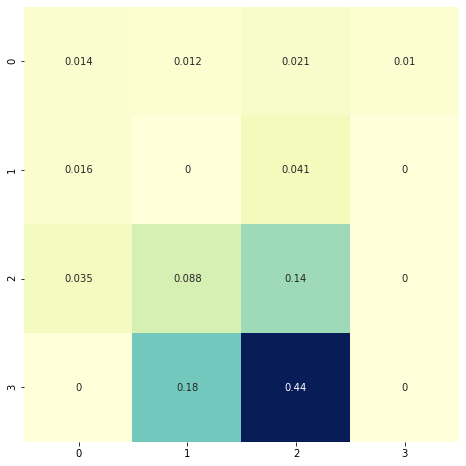

In [7]:
vpi = policy_evaluation(policy , env) 
print("Value: " , vpi)
plt.figure(figsize=(8, 8))
sns.heatmap(vpi.reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False, square=True);

### Policy Iteration

In [8]:
def policy_iteration(env , discount_factor=1.0):
    #1. Initialization
    policy = np.ones((n_states , n_actions))/n_actions

    while True:
        #2. Policy Evaluation
        V = policy_evaluation(policy , env) 
    
        #3. Policy Improvement
        policy_stable = True
        
        for s in range(n_states):  #for each s in States
            old_action = np.argmax(policy[s])            #old_action <- policy[s]
            best_action = np.argmax(one_step_lookahead(s , V))  #policy[s]<- sum(prob(s', r|s,a)) * (reward + gamma*V(s')) 
            if old_action != best_action:           #if old-action != policy(s), then policy-stable -> false
                policy_stable = False 
            policy[s] = np.eye(n_actions)[best_action]   #(Making the index of policy for the best action as 1)
        if policy_stable:         #if policy-stable, then stop and return V  and policy   
            return policy, V

Policy:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
Value:  [0.06661261 0.0537382  0.09460525 0.09459515 0.06663701 0.
 0.13547681 0.         0.06666667 0.13333333 0.3118256  0.
 0.         0.33333333 0.66666667 0.        ]


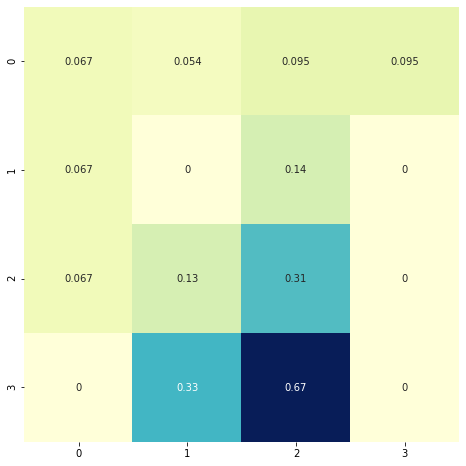

In [9]:
policy , V = policy_iteration(env)
print("Policy: ", policy)
print("Value: " , V)
plt.figure(figsize=(8, 8))
sns.heatmap(V.reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False, square=True);

### Value Iteration

In [10]:
def value_iteration(env , discount_factor = 1.0 , theta = 0.00001 ):
    V = np.zeros(n_states)     #Initialize array V arbitrarily
    
    #Repeat
    while True:    
        delta = 0.0        #delta <- 0
        for s in range(n_states):   #For each s in state:
            v = V[s]               # v <- V(s)
            V[s] = max(one_step_lookahead(s, V , discount_factor = discount_factor))  # V(s) = max(sum(prob(s', r|s,a)) * (reward + gamma*V(s'))) 
            delta = max(delta , abs(v - V[s]))            #delta <- max(delta , |v - V[s]|)
            
        if(delta<theta):                    #terminate on delta < theta (theta is a small positive number)
            break

    #Output a deterministic policy pi such that:
    policy = np.zeros((n_states, n_actions))

    for s in range(n_states):
        best_action = np.argmax(one_step_lookahead(s , V))
        policy[s] = np.eye(n_actions)[best_action]
    
    return policy, V

Policy:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
Value:  [0.00137174 0.00411523 0.01234568 0.00411523 0.00411523 0.
 0.03703704 0.         0.01234568 0.03703704 0.11111111 0.
 0.         0.11111111 0.33333333 0.        ]


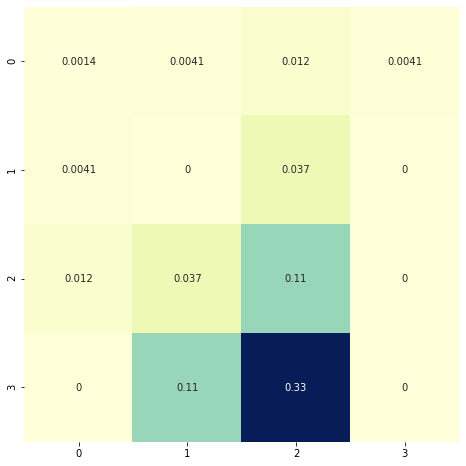

In [11]:
policy , V = value_iteration(env)
print("Policy: ", policy)
print("Value: " , V)
plt.figure(figsize=(8, 8))
sns.heatmap(V.reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False, square=True);

In [ ]:
display.clear_output(wait=True)

total_reward = 0
total_wins = 0
policy, V = value_iteration(env)              #Your iteration method here
for t in range(1000):          #Running for 1000 iterations
    
    is_done = False
    state = env.reset()
    
    while is_done==False:
        action = np.argmax(policy[state])     #Selecting best action from policy
        obs , reward , is_done , info = env.step(action)
        env.render()
        display.clear_output(wait=True)
        total_reward += reward
        state = obs          #Chaning the state to the new obtained observation
        print(total_wins)
        if is_done and reward==1.0:
            print("Won a Game")
            total_wins+=1
            break
print("Total Reward/Wins: ", total_reward)

38
  (Down)
SFFF
FHFH
FFFH
HFFG


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\user1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-bdfc3969f93e>", line 15, in <module>
    display.clear_output(wait=True)
  File "C:\Users\user1\anaconda3\lib\site-packages\IPython\core\display.py", line 1464, in clear_output
    InteractiveShell.instance().display_pub.clear_output(wait)
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 157, in clear_output
    self._flush_streams()
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 80, in _flush_streams
    sys.stderr.flush()
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\iostream.py", line 352, in flush
    if not evt.wait(self.flush_timeout):
  File "C:\Users\user1\anaconda3\lib\threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "C:\Users\user1\anaconda3\lib\th

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\user1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-bdfc3969f93e>", line 15, in <module>
    display.clear_output(wait=True)
  File "C:\Users\user1\anaconda3\lib\site-packages\IPython\core\display.py", line 1464, in clear_output
    InteractiveShell.instance().display_pub.clear_output(wait)
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 157, in clear_output
    self._flush_streams()
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 80, in _flush_streams
    sys.stderr.flush()
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\iostream.py", line 352, in flush
    if not evt.wait(self.flush_timeout):
  File "C:\Users\user1\anaconda3\lib\threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "C:\Users\user1\anaconda3\lib\th

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\user1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-bdfc3969f93e>", line 15, in <module>
    display.clear_output(wait=True)
  File "C:\Users\user1\anaconda3\lib\site-packages\IPython\core\display.py", line 1464, in clear_output
    InteractiveShell.instance().display_pub.clear_output(wait)
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 157, in clear_output
    self._flush_streams()
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 80, in _flush_streams
    sys.stderr.flush()
  File "C:\Users\user1\anaconda3\lib\site-packages\ipykernel\iostream.py", line 352, in flush
    if not evt.wait(self.flush_timeout):
  File "C:\Users\user1\anaconda3\lib\threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "C:\Users\user1\anaconda3\lib\th